## ⚙️ Overview

The workflow is structured as a stateful graph of modular nodes, each performing a distinct step in the summarization pipeline:

### Initialize Workflow
Sets up the workflow state, including input parameters such as the website URL, steps tracker, and generation counters.

### Scrape Article
Retrieves raw webpage content (text, metadata, and structure) from the specified website_address.
This stage ensures clean and usable text data for summarization.

### Summarize Article
Uses an LLM (Gemma2 9B via ChatGroq) to create an informative, structured summary of the scraped content.
Additionally, the model extracts key topics to enrich metadata and improve vector-based retrieval performance.

### Grade Summary vs. Article
The generated summary is validated for factual alignment with the original article using a hallucination checker.

If hallucinations are detected → the summarization step repeats.

If no hallucinations are found → the workflow proceeds to storage.

### Add to Chroma
The validated summary and metadata (topics, source, and title) are stored in a Chroma vector store for future use in retrieval-augmented question-answering workflows.

## 🧩 Key Components

### LLM:
ChatGroq with the model "openai/gpt-oss-20b" (Gemma2 9B equivalent) provides deterministic and fact-consistent summarization.

### Vectorstore:
A Chroma database that persists structured document embeddings, enabling efficient semantic retrieval for later QA tasks.

### LangGraph State Machine:
Implements the workflow logic with StateGraph, allowing for iterative validation (re-summarization on hallucinations) and clear state tracking.

In [1]:
from langgraph.graph import START, END, StateGraph
from exa_py import Exa
from langchain_groq import ChatGroq
from typing_extensions import TypedDict, List, Annotated, Optional,Dict
from IPython.display import Image, display
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser
from langchain_core.output_parsers import JsonOutputParser
from langchain_community.vectorstores.utils import filter_complex_metadata
from IPython.display import display, Audio
from langchain.prompts import PromptTemplate
import numpy as np
import os
import requests
from bs4 import BeautifulSoup
from readability import Document
from urllib.parse import urlparse
import html2text
import cloudscraper
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.schema import Document
from uuid import uuid4
from langchain_community.vectorstores import Chroma
from pathlib import Path
from langchain_core.documents import Document 
from langsmith import traceable
from langchain_community.document_loaders import NewsURLLoader
import os
from langchain.schema.retriever import BaseRetriever
from typing_extensions import TypedDict, List, Annotated
from typing import Optional
from IPython.display import Image, display
from langchain_core.pydantic_v1 import BaseModel, Field

import datetime

C:\Users\artur\anaconda3\envs\dATA_SCIENCE_RAG\lib\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
os.environ["LANGCHAIN_API_KEY"] = 'Your api key here'
os.environ["LANGSMITH_TRACING"]="true"
os.environ["LANGCHAIN_ENDPOINT"]= "https://eu.api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "Project name"

In [3]:
loader = NewsURLLoader(
    urls=["https://www.wired.com/story/uncanny-valley-podcast-move-aside-chatbots-ai-humanoids-are-here/"],
)
docs = loader.load()

In [4]:
docs

[Document(metadata={'title': 'Move Aside, Chatbots: AI Humanoids Are Here', 'link': 'https://www.wired.com/story/uncanny-valley-podcast-move-aside-chatbots-ai-humanoids-are-here/', 'authors': ['Michael Calore', 'Will Knight', 'Kylie Robison'], 'language': 'en', 'description': 'Today on "Uncanny Valley," we talk about why the AI industry is investing in the development of humanoid robots, and what that means for us non-robots.', 'publish_date': datetime.datetime(2025, 9, 18, 19, 45, 20, 241000, tzinfo=tzutc())}, page_content="This week, WIRED learned that OpenAI is ramping up its efforts in robotics—specifically, by hiring researchers who work on AI systems for humanoid robots. Humanoids, robots built to resemble us and perform daily tasks, were famous for their clumsiness just a few years ago. Senior writer Will Knight tells us about how that's rapidly changing on today's episode cohosted by Michael Calore and senior correspondent Kylie Robison.\n\nMentioned in this episode:\n\nOpenAI 

In [5]:
model_name = "intfloat/multilingual-e5-large-instruct"
model_kwargs = {'device': 'cpu',
                  "trust_remote_code" : 'False'}
encode_kwargs = {'normalize_embeddings': True}
embeddings = HuggingFaceEmbeddings(
        model_name=model_name,
        model_kwargs=model_kwargs,
        encode_kwargs=encode_kwargs
    )




C:\Users\artur\anaconda3\envs\dATA_SCIENCE_RAG\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
persist_dir = Path(__file__).resolve().parent / "chroma"

vectorstore = Chroma(persist_directory=persist_dir, embedding_function=embeddings)

C:\Users\artur\AppData\Local\Temp\ipykernel_36820\2593924928.py:3: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(persist_directory=persist_dir, embedding_function=embeddings)


In [7]:
def initialize_workflow(state):
    """
    Initialize question and websites
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updated state with steps, topic, and websites
    """
    # Ensure required fields exist
    if "steps" not in state:
        state["steps"] = []
    if "website_address" not in state:
        state["website_address"] = []

    steps = state["steps"]
    website_address = state.get("website_address", [])
    
    
    # Add initialization steps
    steps.append("topic initialization")
    steps.append("question_asked")
    if website_address:
        steps.append(f"initialized with {len(website_address)} websites")
    
    return {
         
        "website_address": website_address,
        "steps": steps,
       
    }


@traceable
def summarize_article(state, llm, create_article_summarizer,create_topics_identifier):
    """
    Summarize the article and extract main topics using the structured summarizer.
    """

    # Extract from state
    article_text = state["selected_document"]
    steps = state["steps"]

    
    steps.append("summarize_article")

    # Create the summarization pipeline
    summarizer = create_article_summarizer(llm)
    topics_identifier = create_topics_identifier(llm)

    
    summary = summarizer.invoke({"article": article_text})
    topics =  topics_identifier.invoke({"article": article_text})

    # Log for debugging (optional)
    print("📝 Article summarization completed.")
    print(f"Summary: {summary}...")
    print(f"Topics: {topics}")

    # Return updated state
    return {
        **state,
        "summary": summary,
        "topics": topics,
        "steps": steps,
    }




@traceable
def scrape_webpage_content(state):
    """
    Scrapes a webpage and returns its content as part of the updated graph state.

    Args:
        state (dict): The current graph state. Must contain "url".
        scraper_tool (callable): A function that takes a URL and returns a dict
                                 with keys: title, text, source, error.

    Returns:
        dict: Updated state fragment with keys: documents (list of scraped docs)
              and error if scraping fails.
    """
    steps = state["steps"]
    steps.append("web_scraping")

    website_address = state.get("website_address")
    if not website_address:
        return {"error": "No URL provided."}

    loader = NewsURLLoader(
    urls=[website_address],
)
    docs = loader.load()
    print(f"loaded document content:  {docs}")

    

    return {"selected_document": docs}



In [8]:
@traceable
def create_article_summarizer(llm):
    """
    Creates a structured-output summarizer that summarizes an article 
    and extracts main topics in a single call.

    Args:
        llm: The language model used for summarization.

    Returns:
        Callable: A summarization pipeline that outputs summary.
    """

   

    # Define the prompt template
    prompt = PromptTemplate(
        template="""
        You are a professional content summarizer.
        Read the article provided below and:
        1. Write a concise and factual summary (1-3 sentences).
        Do not add anything else!
        
        ARTICLE:
        {article}
        """,
        input_variables=["article"],
    )

    # Combine prompt and model into a reusable summarization pipeline
    summarizer = prompt | llm | StrOutputParser()

    # Return the ready-to-use summarizer pipeline
    return summarizer




In [9]:
def create_topics_identifier(llm):
    """
    Creates a structured-output summarizer that summarizes an article 
    and extracts main topics in a single call.

    Args:
        llm: The language model used for topic extraction.

    Returns:
        Callable: A topics identifier pipeline that outputs article 'topics'.
    """

    

    # Define the prompt template
    prompt = PromptTemplate(
        template="""
        You are a professional content summarizer.
        Read the article provided below and:
        Identify and list the main topics, entities, or concepts mentioned in the article.
        Do not add anything else!
        
        ARTICLE:
        {article}
        """,
        input_variables=["article"],
    )

    # Combine prompt and model into a reusable summarization pipeline
    topic_identifier = prompt | llm | StrOutputParser()

    # Return the ready-to-use summarizer pipeline
    return topic_identifier

In [10]:
@traceable
def add_to_chroma(state,vectorstore):
    """
    Adds the article to Chroma using vectorstore from state.
    Stores title, source, topics, summary in metadata, and article text as page_content.
    """

    

    # Extract article info

    documents = state["selected_document"]  # This is a list
    article = documents[0]  # Get the first (and only) document from the list

    summary = state.get("summary", "")
    topics = state.get("topics", [])
    steps = state.get("steps", [])
    steps.append("add_to_chroma")

    article_text = article.page_content  # ← Use .page_content, not .get("text")
    article_title = article.metadata.get("title", "Untitled")  # ← Access metadata
    article_link = article.metadata.get("link", "")
    article_authors = article.metadata.get("authors", "")
    article_language = article.metadata.get("language", "")
    
    
        
    # Create Document
    doc = Document(
    page_content=article_text,
    metadata={
        "title": article_title,
        "link": article_link,
        "summary": summary,
        "topics": ", ".join(topics) if isinstance(topics, list) else str(topics),
        "language": article_language,
        "authors": ", ".join(article_authors) if isinstance(topics, list) else str(article_authors), 
    }
)

    # Add to Chroma
    doc_id = str(uuid4())
    vectorstore.add_documents(documents=[doc], ids=[doc_id])
    

    print(f"✅ Document added to Chroma: {doc_id}")

    # Update state
    return {
        **state,
        "documents": state.get("documents", []) + [doc],
        "steps": steps
    }

In [11]:
def create_hallucination_checker(llm):
    """
    Function to create a hallucination checker object using a passed LLM model.
    
    Args:
        llm: The language model to be used for checking hallucinations in the student's answer.
        
    Returns:
        Callable: A pipeline function that checks if the student's answer contains hallucinations.
    """
    

    # Define the prompt template
    prompt = PromptTemplate(
        template="""
        You are professional fact checker,  you need to check summary: {summary}, which is made from an article: {article}, was there made any factual mistakes, hallucinations.
        If there are mistakes , return 'yes', if no mistakes, return 'no'
        return answer as yes or no.
        """,
        input_variables=["article", "summary"],
    )
    
    # Combine the prompt with the structured LLM hallucination checker
    hallucination_grader = prompt | llm |  StrOutputParser()

    # Return the hallucination checker object
    return hallucination_grader

In [12]:
def grade_summary_v_article(state,llm,create_hallucination_checker ):
    """
    Determines whether the generation is grounded in the document and answers the question.
    """
    print("---CHECK HALLUCINATIONS---")
    article_text = state["selected_document"]
    steps = state["steps"]
    summary = state.get("summary")
    
    steps.append("Check for hallucinations")
    hallucination_grader = create_hallucination_checker(llm)
    # Grading hallucinations
    score = hallucination_grader.invoke(
        {"article": article_text, "summary": summary}
    )
    

    # Check hallucination
    if score == "yes":
        print("---Found hallucinations---")
        return "Hallucinations"
        
    if score == "no":
        print("---no hallucinations---")
        return "No hallucinations"
    

In [13]:

def article_summarization_graph(vectorstore):
    """
    Builds the scrape/search workflow graph.

    Args:
        search_type (str): The type of search strategy to use.
        k (int): Number of top documents to retrieve.
    """

    class GraphState(TypedDict):
        """
        Represents the state of our graph.
        Attributes:
            question: question
            generation: LLM generation
            search: whether to add search
            documents: list of documents
            generations_count : generations count
        """
        question: str
        generation: str
        search: str
        documents: List[str]
        steps: List[str]
        generation_count: int
        search_type: str
        k: int
        website_address: str
        summary: str
        topics: List[str]
        selected_document: str

    #search_type =  search_type
    #k = k 
    #website_address = website_address
    
    # LLM
    llm = ChatGroq(
        model="openai/gpt-oss-20b",  # Specify the Gemma2 9B model
        temperature=0.0,
        max_tokens=4000,
        max_retries=3,
        api_key="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"
        
    )
    
   

    # Graph
    workflow = StateGraph(GraphState)

    # Nodes
    workflow.add_node("initialize_workflow", lambda state: initialize_workflow(state))
     
    workflow.add_node("scrape_article", lambda state: scrape_webpage_content(state))
    workflow.add_node("summarize_article", lambda state: summarize_article(state, llm, create_article_summarizer,create_topics_identifier))
    workflow.add_node("add_to_chroma", lambda state: add_to_chroma(state,vectorstore))

    # Graph structure
    workflow.set_entry_point("initialize_workflow")

    workflow.add_edge("initialize_workflow", "scrape_article")
    workflow.add_edge("scrape_article", "summarize_article")
    workflow.add_conditional_edges(
        "summarize_article",
        lambda state: grade_summary_v_article(state,llm,create_hallucination_checker),
        {
            "Hallucinations": "summarize_article",
            "No hallucinations": "add_to_chroma",
        },
    )
    
    
    workflow.add_edge("add_to_chroma", END)

    # Compile and return
    custom_graph = workflow.compile()
    return custom_graph

In [14]:
summarizer_graph=  article_summarization_graph(vectorstore)

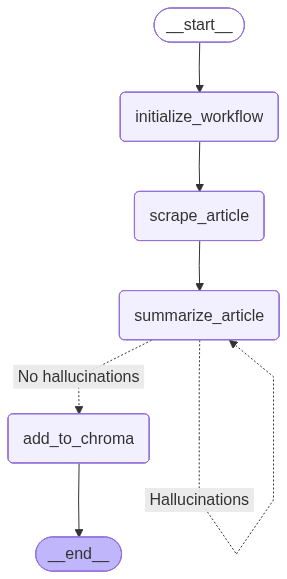

In [15]:
diagram = summarizer_graph.get_graph(xray=True).draw_mermaid_png()

# Save to file (optional)
with open("graph.png", "wb") as f:
    f.write(diagram)

display(Image(diagram))

In [17]:
result = summarizer_graph.invoke({
    "website_address": "https://www.wired.com/story/the-repair-app/#intcid=_wired-article-bottom-recirc_7ddd0b22-d72d-4c11-8308-7292b683d690_roberta-similarity1",
})

print(result)

loaded document content:  [Document(metadata={'title': 'Need Something Repaired? Now There’s an App for That', 'link': 'https://www.wired.com/story/the-repair-app/#intcid=_wired-article-bottom-recirc_7ddd0b22-d72d-4c11-8308-7292b683d690_roberta-similarity1', 'authors': ['Boone Ashworth'], 'language': 'en', 'description': 'The Repair App is a new platform that connects trusted repair service providers with people who need their stuff fixed. It couldn’t come at a better time for economically strapped consumers.', 'publish_date': datetime.datetime(2025, 10, 18, 9, 0, tzinfo=tzutc())}, page_content="A new app with a straightforward name wants to make it easier for people to fix their stuff by helping them find trustworthy repair services near them.\n\nThe Repair App launched today, on a day that’s being celebrated as International Repair Day. The app is currently available in beta form in the US and France, because that’s where cofounders Robert Lise and Caleb Faruki reside, respectively. 

In [13]:
result = summarizer_graph.invoke({
    "question": "",  # Add if needed
    "generation": "",
    "search": "",
    "documents": [],
    "steps": [],

    "website_address": "https://cointelegraph.com/news/crypto-markets-could-ease-with-us-gov-shutdown-ending",
    "summary": "",
    "topic":"bitcoin"
})

print(result)

Failed to use model_dump to serialize <class 'langchain_core.runnables.base.RunnableSequence'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic.v1.main.ModelMetaclass'>)


loaded document content:  [Document(metadata={'title': 'Crypto could get relief as US Senate cuts deal to end shutdown: Report', 'link': 'https://cointelegraph.com/news/crypto-markets-could-ease-with-us-gov-shutdown-ending', 'authors': ['Brayden Lindrea'], 'language': 'en', 'description': 'US senators have reportedly reached a deal to end the government shutdown, which could ease pressure on the crypto market.', 'publish_date': None}, page_content='The crypto market could soon see some much-needed relief after the US Senate reached an agreement on a three-part budget deal to end the government shutdown, Politico reports.\n\nPending legislation to fund the US government has more than enough support to pass the 60-vote threshold, Politico reported on Sunday, citing two people familiar with the matter.\n\nIt was Republican Senate Majority Leader John Thune’s 15th attempt to win Democratic support for a House-approved bill, putting the record 40-day government shutdown within reach of bein

In [14]:
result = summarizer_graph.invoke({
    "question": "",  # Add if needed
    "generation": "",
    "search": "",
    "documents": [],
    "steps": [],

    "website_address": "https://cointelegraph.com/news/china-raises-alarm-united-states-lubian-127k-bitcoin-hack",
    "summary": "",
    "topic":"bitcoin"
})

print(result)

Failed to use model_dump to serialize <class 'langchain_core.runnables.base.RunnableSequence'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic.v1.main.ModelMetaclass'>)


loaded document content:  [Document(metadata={'title': 'China raises alarm over alleged US role in one of the largest Bitcoin hacks', 'link': 'https://cointelegraph.com/news/china-raises-alarm-united-states-lubian-127k-bitcoin-hack', 'authors': ['Helen Partz'], 'language': 'en', 'description': 'China’s national cyber defense agency, CVERC, has flagged the alleged involvement of the US government in the 2020 LuBian mining pool hack, valued at billions of dollars.', 'publish_date': None}, page_content='China’s national cyber defense agency has made big claims around the alleged role of the US in the multibillion-dollar hack of LuBian, once a major Chinese Bitcoin mining pool.\n\nThe Chinese National Computer Virus Emergency Response Center (CVERC), a state-backed cyber defense agency, on Sunday published a technical analysis report on the 127,272 Bitcoin (BTC) stolen in the LuBian hack.\n\nAlthough the hack occurred in December 2020, it remained largely unknown to the public until recent

In [15]:
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 15, })

In [16]:
retriever.invoke("humanoid")

Number of requested results 15 is greater than number of elements in index 3, updating n_results = 3


[Document(metadata={'authors': 'Helen Partz', 'language': 'en', 'link': 'https://cointelegraph.com/news/china-raises-alarm-united-states-lubian-127k-bitcoin-hack', 'summary': 'China’s national cyber defense agency, CVERC, alleges that the U.S. government was involved in the 2020 LuBian mining‑pool hack that stole 127,272\u202fBTC (≈$14.5\u202fbillion). The report claims the U.S. had custody of the stolen coins for over a year before formally filing a forfeiture, and that the dormancy of the funds suggests a state‑orchestrated operation rather than ordinary hacking. The case adds a geopolitical dimension to one of the largest crypto thefts ever recorded.', 'title': 'China raises alarm over alleged US role in one of the largest Bitcoin hacks', 'topics': 'CVERC, LuBian mining pool, 127,272 BTC hack, U.S. government involvement, Prince Group, Chen Zhi, Arkham data, Bitcoin theft, state‑sponsored hacking, U.S. DOJ forfeiture, geopolitical implications, cryptocurrency security'}, page_conten

In [17]:


# Helper function to add instructions to the query
def get_detailed_instruct(task_description: str, query: str) -> str:
    """Format a query with a task description to guide the model."""
    return f'Instruct: {task_description}\nQuery: {query}'

# Custom Retriever class with instruction-augmented queries
class InstructRetriever(BaseRetriever):
    """Retriever that adds instruction to queries before retrieval."""
    
    base_retriever: BaseRetriever = Field(...)
    task_description: str = Field(...)

    def _get_relevant_documents(self, query: str) -> List[Document]:
        """Add instruction to the query before passing to the base retriever."""
        formatted_query = get_detailed_instruct(self.task_description, query)
        return self.base_retriever.invoke(formatted_query)


In [18]:
task_description = "Retrieve most relevant documents to the query"

# Instruction-based retriever
instruct_retriever = InstructRetriever(
    base_retriever=retriever,
    task_description=task_description
)

In [88]:
instruct_retriever = InstructRetriever(base_retriever=retriever, task_description=task_description)
instruct_retriever.invoke("United States Congressional Budget Office (CBO)")

Number of requested results 15 is greater than number of elements in index 5, updating n_results = 5


[Document(metadata={'authors': "['Lily Hay Newman']", 'language': 'en', 'link': 'https://www.wired.com/story/the-government-shutdown-is-a-ticking-cybersecurity-time-bomb/', 'summary': 'The U.S. Congressional Budget Office reported a hack during a five‑week government shutdown and has added monitoring and security controls, while other agencies like CISA face staff cuts that may hinder cybersecurity efforts. Experts warn that gaps in routine tasks such as patching and monitoring during the shutdown could weaken federal defenses now and create a backlog of security work when employees return.', 'title': 'The Government Shutdown Is a Ticking Cybersecurity Time Bomb', 'topics': '- Government shutdown  \n- United States Congressional Budget Office (CBO)  \n- Cyber hack / breach  \n- Suspected foreign actor  \n- Monitoring and security controls  \n- Supplemental Nutrition Assistance Program (SNAP)  \n- Air traffic control personnel shortages  \n- Social Security Administration  \n- Federal c